In [1]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = load_file('data/microarray_data.csv')[:, 1:].T
print(labels.shape, dataset.shape)
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

(969,) (969, 12179)
Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


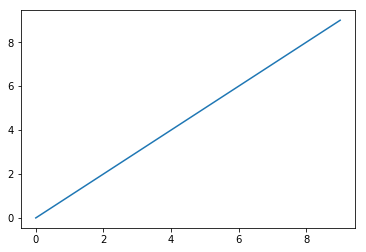

In [3]:
plt.plot(np.arange(10), np.arange(10))
plt.show()

Train and test scores: 0.9655647382920111 0.7695473251028807


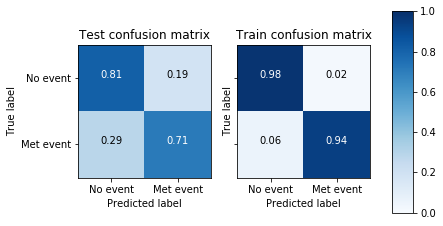

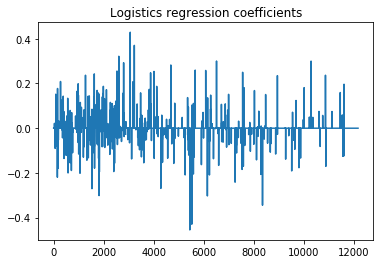

Train and test scores: 0.9228650137741047 0.7489711934156379


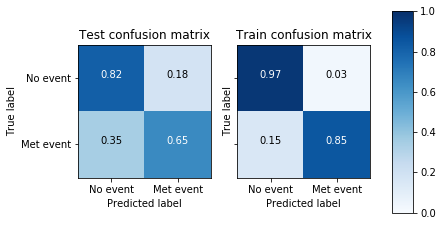

Train and test scores: 0.8457300275482094 0.6337448559670782


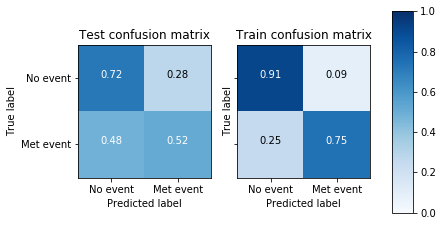

Train and test scores: 0.8815426997245179 0.6995884773662552


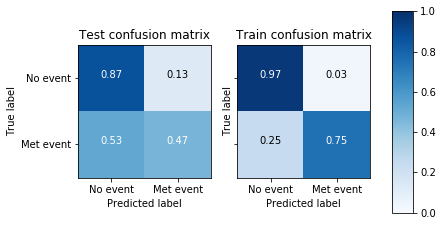

In [4]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_train, y_train, X_test, y_test)

Train and test scores: 1.0 0.7325102880658436


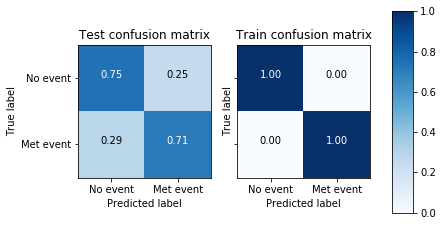

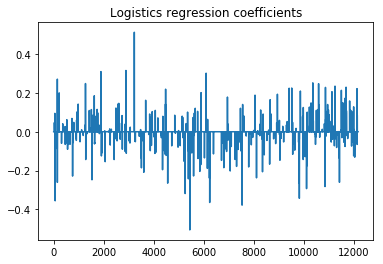

Train and test scores: 1.0 0.7448559670781894


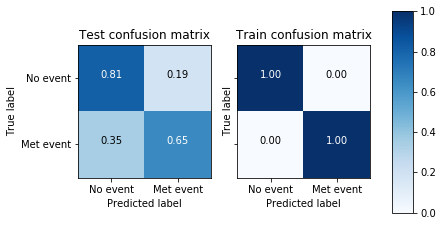

Train and test scores: 0.8457300275482094 0.6296296296296297


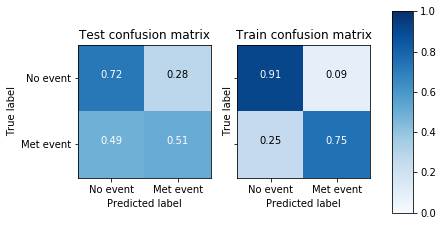

Train and test scores: 0.8691460055096418 0.7078189300411523


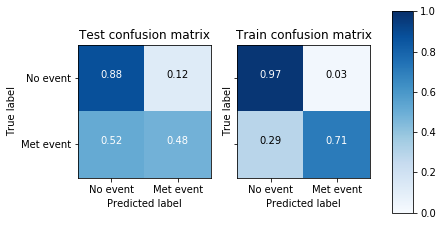

In [5]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_std_train, y_train, X_std_test, y_test)

In [6]:
#test thresholding for loogit regression
threshold = 0.1
preds_train = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_train)[:,1]])
preds_test = np.array([1 if x > threshold else 0 for x in clf_logit.predict_proba(X_std_test)[:,1]])
cm_train = confusion_matrix(y_train, preds_train)
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test = confusion_matrix(y_test, preds_test)
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
print(cm_train)
print(cm_test)

[[0.776 0.224]
 [0.    1.   ]]
[[0.475 0.525]
 [0.135 0.865]]


417
Train and test scores: 0.9917355371900827 0.7325102880658436


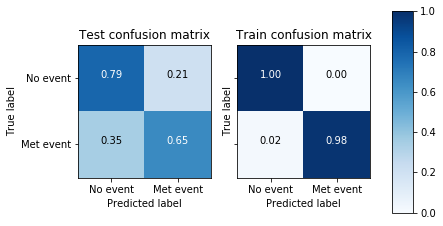

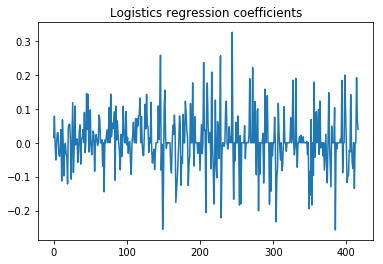

Train and test scores: 0.9986225895316805 0.7530864197530864


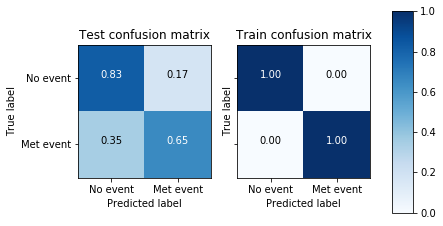

Train and test scores: 0.7796143250688705 0.6255144032921811


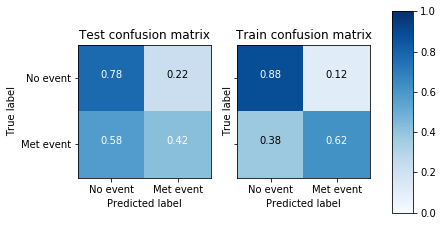

Train and test scores: 0.7892561983471075 0.5720164609053497


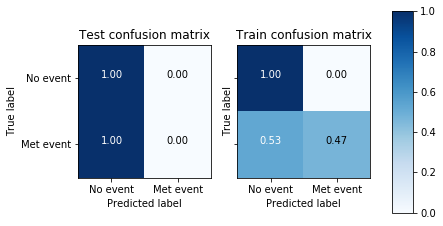

In [7]:
pca_transform = PCA(n_components=0.95, svd_solver='full').fit(X_std_train)
print(pca_transform.n_components_)
X_pca_train = pca_transform.transform(X_std_train)
X_pca_test = pca_transform.transform(X_std_test)
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_pca_train, y_train, X_pca_test, y_test)

In [8]:
mlcc_results = []
filenames = []
for filename in os.listdir('./mlcc_results/'):
    if filename.endswith('.RData'):
        mlcc_results.append(tuple(read_mlcc_result(filename, 726)))
        filenames.append(filename)
print(filenames)
#segmentation, mBIC, dimensionalities = read_mlcc_result(100, 969)

['output50_4_40_30.RData', 'output50_8_40_30.RData', 'output100_8_40_30.RData', 'output150_8_40_30.RData', 'output100_4_40_30.RData', 'output10_8_40_30.RData', 'output75_4_40_30.RData', 'output20_4_40_30.RData', 'output20_8_40_30.RData']


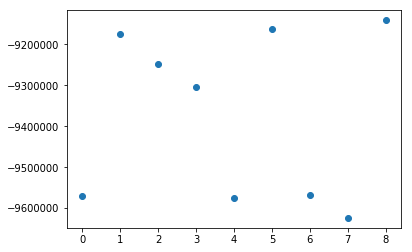

Highest mBIC is from output20_8_40_30.RData


In [9]:
mBICs = list(map(lambda x : x[1][0], mlcc_results))
plt.figure()
plt.scatter(np.arange(len(mBICs)), mBICs)
plt.show()
max_index = np.argmax(mBICs)
print('Highest mBIC is from {}'.format(filenames[max_index]))

In [10]:
segmentation = mlcc_results[max_index][0]
dimensionalities = mlcc_results[max_index][2]
print(segmentation, dimensionalities)

X_mlcc_train = apply_mlcc_dim_reduction(X_std_train, segmentation, dimensionalities)
X_mlcc_test = apply_mlcc_dim_reduction(X_std_test, segmentation, dimensionalities)

[10  5  5 ...  1  7 18] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


Train and test scores: 0.8484848484848485 0.5679012345679012


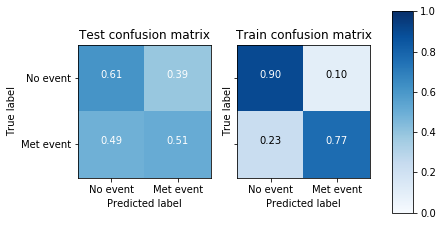

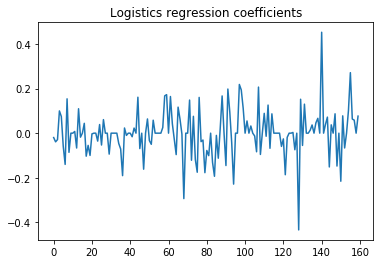

Train and test scores: 0.9517906336088154 0.691358024691358


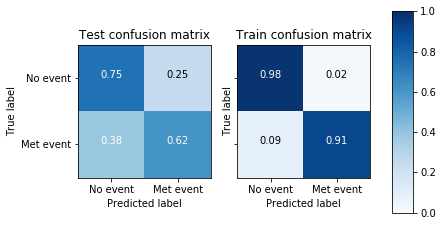

Train and test scores: 0.7961432506887053 0.5802469135802469


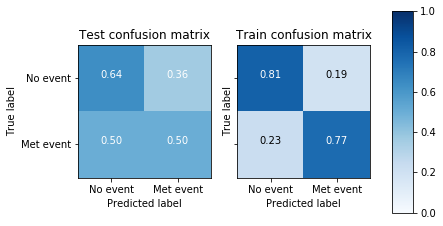

Train and test scores: 0.8278236914600551 0.6460905349794238


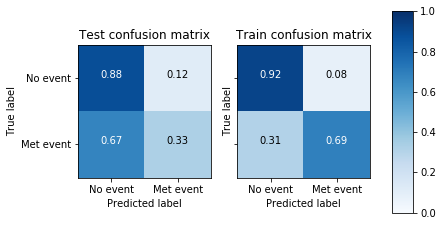

In [11]:
(clf_logit, clf_svm, clf_tree, clf_forest) = fit_models(X_mlcc_train, y_train, X_mlcc_test, y_test)